In [1]:
using Plots
using Printf

# Path to resources
PATHCSIM="/home/gabriel/Polytech/S9/kuka_multitache/";
include("/home/gabriel/Polytech/S9/kuka_multitache/lib-robotique.jl"); 
include("/home/gabriel/Polytech/S9/kuka_multitache/lib-CSim.jl");

In [2]:
function multi_task(θinit,g1,g2,tol_1=1e-3,tol_2=1e-3,do_plot=0)
    println("[Task Hier.] Starting task hierarchy...")
    formatted_g1 = join([@sprintf("%.2f", x) for x in g1], ", ")
    println("[Task Hier.] Goal position end effector = ", formatted_g1 )
    formatted_g2 = join([@sprintf("%.2f", x) for x in g2], ", ")
    println("[Task Hier.] Goal CoM's position = ", formatted_g2)
    
    # Init variables (J1, J2, g_1, g_2, tol_1, tol_2) (e_1, e_2)
    e1 = e2 = [3;3;3] # init high value of error
    θ = θinit 
    CoMactuel = CoM0
    #DEBUG
    steps = 100

    # Init vectors of plot (trajectory_θ, trajectory_z, trajectory_CoM)
    trajectory_θ = Vector{Vector{Float64}}()
    trajectory_z = Vector{Float64}()
    trajectory_CoM = Vector{Vector{Float64}}()

    # Calculate My current theta********

    current_p = MGD(θinit, rob)[1:3, 4]

    # Caclulate e_1 et e_2, update les jacobienes et les crop
    println("[Task Hier.] Iterating...")
        for i = 1:steps       
            J1 = Jacobian(θ,rob,current_p)
            J1_crop = J1[3:3, :]
            J2 = JacobianCoM(θ,rob,CoM0)
            J2_crop = J2[1:2,:]

            e1 = g1 - current_p
            e2 = g2 - CoMactuel

            # Calculer J1 et son action u1 = j_1+ e_1
            u1 = pinv(J1_crop)*e1[3]

            # Calculate its projection P1 = I - J_1+J_1

            P1 = Matrix{Float64}(I, 7, 7) - pinv(J1_crop)*J1_crop #*** why is it 1x1
    
            # Calculater u2 = (J2Pi)+*(e2-J1u1) # since I cropt the jacobian I have to crop and isolate the error on the same axis
            u2 = pinv(J2_crop*P1)*(e2[1:2,:]-J2_crop*u1)

            # Calculate u_f = u1 + u2

            uf = u1 + u2

            # update θ = θ +  u_f*dt 
            θ = vec(θ + uf)
            # print("θ size",size(θ))
            setjointposition(clientID,θ,7,0,objectname_kuka)
            sleep(0.05)

            # update CoM and current position
            current_p = MGD(θ, rob)[1:3, 4]
            CoMactuel = vec(CoM(θ,rob)[1:3,:])
            push!(trajectory_θ,θ)
            push!(trajectory_z,current_p[3])
            push!(trajectory_CoM, CoMactuel)

            #check convergence
            if ((abs(e1[3]) < tol_1 )&& (norm(e2[1:2]) < tol_2))
                println("[Task Hier.] Done in ",i," steps. Error 1 = ",@sprintf("%.3f",abs(e1[3]))," error 2 = ",@sprintf("%.3f",norm(e2[1:2])) )
                break
            end

            if (i == 100)
                println("[Task Hier.] Done in ",steps," steps. Error 1 = ",@sprintf("%.3f",abs(e1[3]))," error 2 = ",@sprintf("%.3f",norm(e2[1:2])) )
            end
        end

        
        
    
    
    if do_plot == 1
        # Extract x, y, z components of CoM for plotting
        CoM_value_x = [element[1] for element in trajectory_CoM]
        CoM_value_y = [element[2] for element in trajectory_CoM]
        CoM_value_z = [element[3] for element in trajectory_CoM]

        # Plot CoM values for x, y, and z
        pCoM_xy = plot(CoM_value_x, label="CoMₓ", xlabel="Iteration", ylabel="Position", title="CoM Components (X & Y)")
        plot!(pCoM_xy, CoM_value_y, label="CoMᵧ")
        # plot!(pCoM_xy, CoM_value_z, label="CoM𝓏", linestyle=:dash)

        # Plot joint angles θ
        pθ = hcat(trajectory_θ...).* 180 / pi  # Convert trajectory_θ to a matrix
        pθ_plot = plot(pθ', label=["θ₁" "θ₂" "θ₃" "θ₄" "θ₅" "θ₆" "θ₇"], xlabel="Iteration", ylabel="Joint Angles", title="Joint Angles over Iterations")

        # θ1_values = [trajectory_θ[i][1] for i in 1:length(trajectory_θ)] .* 180 / pi
        # pθ_plot = plot(θ1_values, label="θ₁", xlabel="Iteration", ylabel="Joint Angle (degrees)", title="Joint Angle θ₁ over Iterations")
        # println("")

        # Plot Z component (robot height)
        pz = plot(trajectory_z, label="z", xlabel="Iteration", ylabel="Height (z)", title="Z Component of CoM")

        # Arrange subplots for CoM, Z, and θ
        p = plot(pCoM_xy, pz, pθ_plot, layout=(3, 1),
                titlefontsize=4,
                guidefontsize=4,
                tickfontsize=4,
                legendfontsize=4,)
        display(p)

        # display(pθ_plot)
        # display(pCoM_xy)
        # display(pz)
    end

    formatted_trajector_θ = join([@sprintf("%.2f", x) for x in trajectory_θ[end].* 180/pi], ", ")
    println("[Task Hier.] Final θ angles = ", formatted_trajector_θ)
    return θ
end

multi_task (generic function with 4 methods)

Connected
[Task Hier.] Starting task hierarchy...
[Task Hier.] Goal position end effector = -0.37, -0.04, 0.50
[Task Hier.] Goal CoM's position = 0.00, 0.10, 0.64
[Task Hier.] Iterating...
[Task Hier.] Done in 15 steps. Error 1 = 0.000 error 2 = 0.009
[Task Hier.] Final θ angles = -19.90, -6.06, -62.31, -124.99, 53.91, 126.77, 46.24


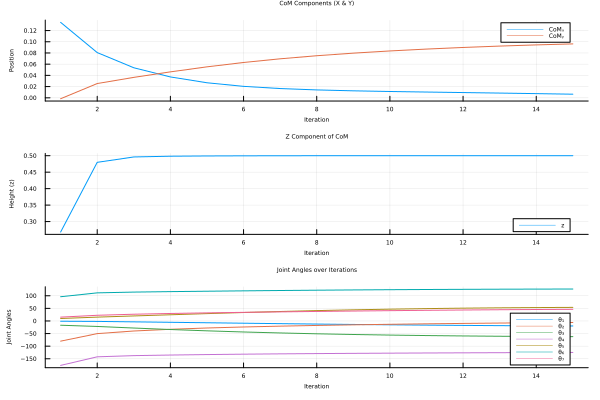

7-element Vector{Float64}:
 -0.3473334240208117
 -0.10584666148258838
 -1.0874338004264146
 -2.1815268921190127
  0.9408763083166054
  2.2126136853227596
  0.8070646891824542

In [3]:
# Start of the simulation
global clientID=startsimulation(simx_opmode_oneshot) # On lance une instance de connexion avec VREP
if clientID==0 println("Connected")
    init_pos()
    else println("Connection error")
end

# Main logic

sleep(2)

global rob=CreateRobotKukaLwr();
global θinit=[0.143019, -0.109465, -0.011994, -1.1788, -0.154233, 0.93555, 0.264868];
global CoM0=[-0.0844, -0.01223, 0.6370];

CoM_target = [0, 0.1 , CoM0[3]]
pinit = MGD(θinit,rob)
global pinit = pinit[1:3,4]

# Task hirearchy
Z_target=[pinit[1], pinit[2], 0.5];

θ = multi_task(θinit,Z_target,CoM_target,1e-2,1e-2,1)
